# HW4: Particle Swarm Optimization

### Here is the reference to the dataset I am using [Alzheimer’s Prediction Dataset (Global)]: https://www.kaggle.com/datasets/ankushpanday1/alzheimers-prediction-dataset-global

This notebook implements an enhanced version of Particle Swarm Optimization (PSO) for training a neural network to predict Alzheimer's diagnosis. It incorporates:

- Shared random numbers for velocity updates on connections to the same neuron
- Gaussian mutation for exploration

The results are compared with HW0 (Backpropagation) and HW1 (Evolution Strategies).

In [22]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense


### Preprocess Alzheimer's Dataset

In [23]:
def load_alzheimers_data():
    df = pd.read_csv("alzheimers_data.csv")
    selected_columns = [
        "Age", "Gender", "Education Level", "BMI", "Physical Activity Level",
        "Smoking Status", "Diabetes", "Hypertension", "Cholesterol Level",
        "Family History of Alzheimer’s", "Alzheimer’s Diagnosis"
    ]
    df = df[selected_columns].copy()

    for col in ["Gender", "Physical Activity Level", "Smoking Status", "Diabetes",
                "Hypertension", "Cholesterol Level", "Family History of Alzheimer’s", "Alzheimer’s Diagnosis"]:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

    X = df.drop(columns=["Alzheimer’s Diagnosis"]).values
    y = df["Alzheimer’s Diagnosis"].values
    X = StandardScaler().fit_transform(X)

    class_0 = np.where(y == 0)[0]
    class_1 = np.where(y == 1)[0]
    np.random.shuffle(class_0)
    np.random.shuffle(class_1)

    test_idx = np.concatenate([class_0[:100], class_1[:100]])
    train_idx = np.concatenate([
        np.random.choice(class_0[100:], size=43570, replace=True),
        np.random.choice(class_1[100:], size=30713, replace=True)
    ])

    np.random.shuffle(train_idx)

    return X[train_idx], y[train_idx], X[test_idx], y[test_idx]

### Particle Class

In [24]:
class Particle:
    def __init__(self, input_dim, enhanced=True):
        self.enhanced = enhanced
        self.input_dim = input_dim
        self.model = self.build_model()
        self.position = self.model.get_weights()
        self.velocity = [np.random.randn(*w.shape) * 0.1 for w in self.position]
        self.q = float("inf")

    def build_model(self):
        model = Sequential()
        model.add(Dense(self.input_dim, activation='sigmoid', input_dim=self.input_dim))
        model.add(Dense(self.input_dim * 2, activation='sigmoid'))
        model.add(Dense(1, activation='sigmoid'))
        return model

    def evaluate_q(self, X, y, b1, b2):
        self.model.set_weights(self.position)
        preds = np.rint(self.model.predict(X, verbose=0))
        cm = confusion_matrix(y, preds)
        FP = cm[0, 1]
        FN = cm[1, 0]
        self.q = (FP + FN) / (b1 + b2) + 10 * (max(0, FP / b1 - 0.1) + max(0, FN / b2 - 0.1))

    def update_position(self):
        self.position = [p + v for p, v in zip(self.position, self.velocity)]

    def update_velocity(self, best_pos, global_best_pos):
        new_velocity = []
        for i, (v, p, bp, gb) in enumerate(zip(self.velocity, self.position, best_pos, global_best_pos)):
            if self.enhanced:
                r1 = np.random.rand()
                r2 = np.random.rand()
                inertia = 0.7 * v
                cognitive = 1.5 * r1 * (bp - p)
                social = 2.0 * r2 * (gb - p)
                mutation = np.random.normal(0, 0.01, size=v.shape)
                new_velocity.append(inertia + cognitive + social + mutation)
            else:
                new_velocity.append(0.7 * v + 1.5 * np.random.rand(*v.shape) * (bp - p)
                                    + 2.0 * np.random.rand(*v.shape) * (gb - p))
        self.velocity = new_velocity

### PSO Optimizer

In [25]:
def pso_train(X_train, y_train, input_dim, enhanced=True):
    particles = [Particle(input_dim, enhanced=enhanced) for _ in range(30)]
    b1, b2 = np.sum(y_train == 0), np.sum(y_train == 1)
    global_best = None
    global_best_q = float('inf')
    convergence = []
    for gen in range(50):
        print(f"Generation {gen + 1}")
        for p in particles:
            p.evaluate_q(X_train, y_train, b1, b2)
            if p.q < global_best_q:
                global_best_q = p.q
                global_best = p

        for p in particles:
            p.update_velocity(global_best.position, global_best.position)
            p.update_position()

        convergence.append(global_best_q)
        print(f"Best q: {global_best_q:.4f}")

    return global_best, convergence

### Evaluation

In [27]:
def evaluate_and_plot(best_particle, X_train, y_train, X_test, y_test, label):
    best_particle.model.set_weights(best_particle.position)
    y_train_pred = np.rint(best_particle.model.predict(X_train, verbose=0))
    y_test_pred = np.rint(best_particle.model.predict(X_test, verbose=0))
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_title(f"{label} - Training Confusion Matrix")
    sns.heatmap(cm_test, annot=True, fmt="d", cmap="Greens", ax=axes[1])
    axes[1].set_title(f"{label} - Testing Confusion Matrix")
    plt.tight_layout()
    plt.show()
    return cm_train, cm_test

### Run PSO

Training with plain PSO...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Generation 1
Best q: 9.1517
Generation 2
Best q: 5.6331
Generation 3
Best q: 5.1362
Generation 4
Best q: 5.1362
Generation 5
Best q: 5.1362
Generation 6
Best q: 5.0913
Generation 7
Best q: 5.0913
Generation 8
Best q: 5.0913
Generation 9
Best q: 5.0057
Generation 10
Best q: 5.0057
Generation 11
Best q: 5.0057
Generation 12
Best q: 5.0057
Generation 13
Best q: 5.0057
Generation 14
Best q: 5.0057
Generation 15
Best q: 5.0057
Generation 16
Best q: 5.0057
Generation 17
Best q: 5.0057
Generation 18
Best q: 5.0057
Generation 19
Best q: 5.0057
Generation 20
Best q: 5.0057
Generation 21
Best q: 5.0057
Generation 22
Best q: 5.0057
Generation 23
Best q: 5.0057
Generation 24
Best q: 5.0057
Generation 25
Best q: 5.0057
Generation 26
Best q: 5.0057
Generation 27
Best q: 5.0057
Generation 28
Best q: 5.0057
Generation 29
Best q: 5.0057
Generation 30
Best q: 5.0057
Generation 31
Best q: 5.0057
Generation 32
Best q: 5.0057
Generation 33
Best q: 5.0057
Generation 34
Best q: 5.0057
Generation 35
Best q: 5

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Generation 1
Best q: 8.4954
Generation 2
Best q: 6.5653
Generation 3
Best q: 6.5653
Generation 4
Best q: 6.4823
Generation 5
Best q: 6.2542
Generation 6
Best q: 6.2542
Generation 7
Best q: 6.2542
Generation 8
Best q: 6.2542
Generation 9
Best q: 6.2542
Generation 10
Best q: 6.2542
Generation 11
Best q: 6.2542
Generation 12
Best q: 6.2542
Generation 13
Best q: 6.2542
Generation 14
Best q: 6.2542
Generation 15
Best q: 6.2542
Generation 16
Best q: 6.2542
Generation 17
Best q: 6.2542
Generation 18
Best q: 6.2542
Generation 19
Best q: 6.2542
Generation 20
Best q: 6.2542
Generation 21
Best q: 6.2542
Generation 22
Best q: 6.2542
Generation 23
Best q: 6.2542
Generation 24
Best q: 6.2542
Generation 25
Best q: 6.2542
Generation 26
Best q: 6.2542
Generation 27
Best q: 6.2542
Generation 28
Best q: 6.2542
Generation 29
Best q: 6.2542
Generation 30
Best q: 6.2542
Generation 31
Best q: 6.2542
Generation 32
Best q: 6.2542
Generation 33
Best q: 6.2542
Generation 34
Best q: 6.2542
Generation 35
Best q: 6

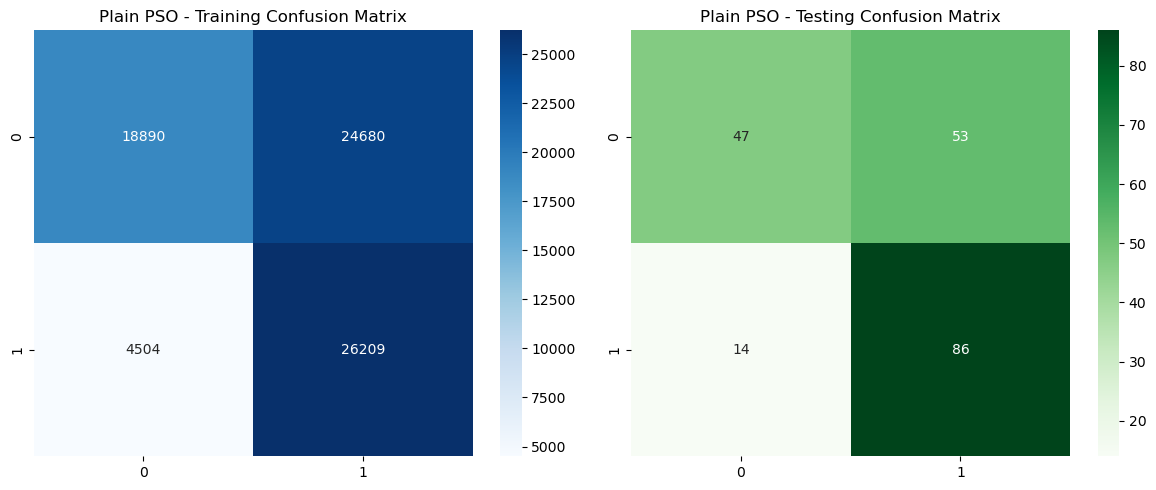

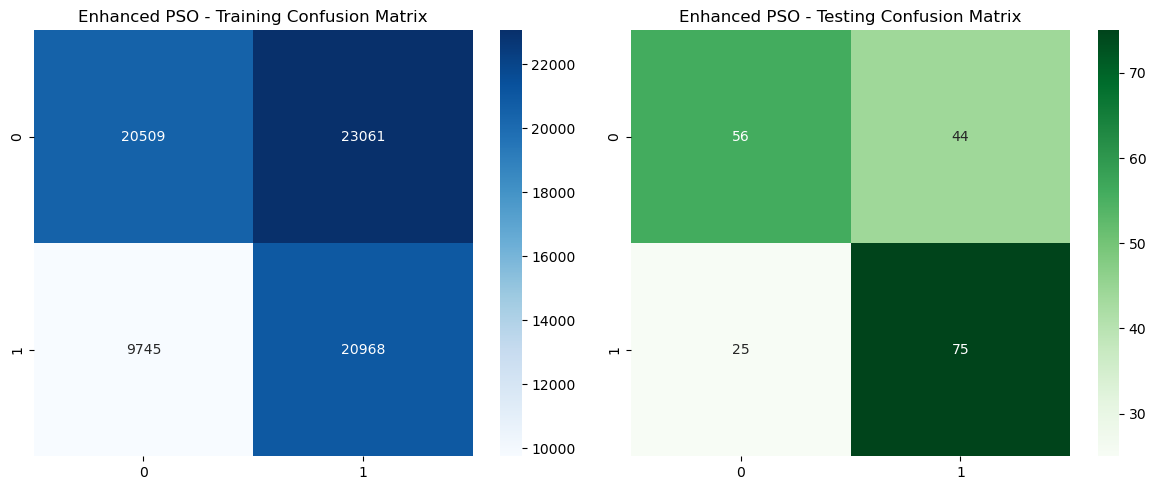

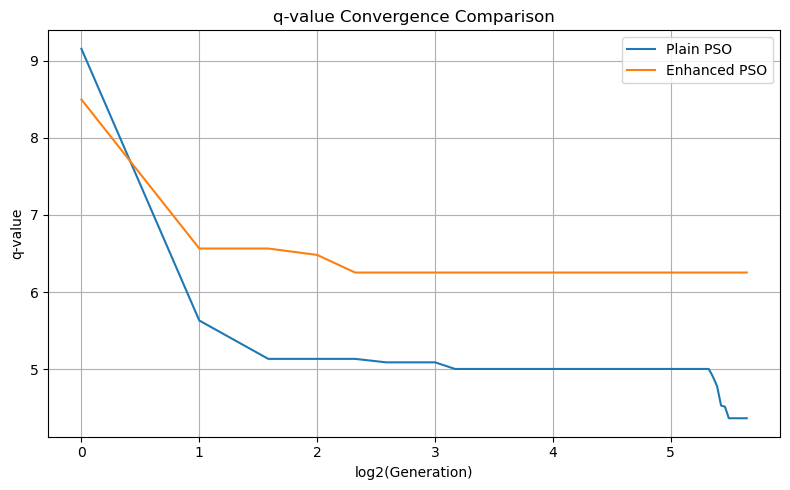

In [28]:
if __name__ == "__main__":
    X_train, y_train, X_test, y_test = load_alzheimers_data()
    print("Training with plain PSO...")
    plain_best, plain_conv = pso_train(X_train, y_train, X_train.shape[1], enhanced=False)
    print("Training with enhanced PSO...")
    enhanced_best, enhanced_conv = pso_train(X_train, y_train, X_train.shape[1], enhanced=True)

    evaluate_and_plot(plain_best, X_train, y_train, X_test, y_test, "Plain PSO")
    evaluate_and_plot(enhanced_best, X_train, y_train, X_test, y_test, "Enhanced PSO")

    plt.figure(figsize=(8, 5))
    plt.plot(np.log2(np.arange(1, len(plain_conv)+1)), plain_conv, label='Plain PSO')
    plt.plot(np.log2(np.arange(1, len(enhanced_conv)+1)), enhanced_conv, label='Enhanced PSO')
    plt.xlabel("log2(Generation)")
    plt.ylabel("q-value")
    plt.title("q-value Convergence Comparison")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
